# 5. Anomaly Detection (20 points)
This implements and compares different anomaly detection methods on the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix
from scipy.stats import zscore
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('/content/cleaned.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4534 entries, 0 to 4533
Data columns (total 46 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Name                                    4534 non-null   float64
 1   Epoch Date Close Approach               4534 non-null   object 
 2   Relative Velocity km per hr             4534 non-null   float64
 3   Miles per hour                          4534 non-null   float64
 4   Miss Dist.(Astronomical)                4534 non-null   float64
 5   Miss Dist.(lunar)                       4534 non-null   float64
 6   Miss Dist.(kilometers)                  4534 non-null   float64
 7   Miss Dist.(miles)                       4534 non-null   float64
 8   Jupiter Tisserand Invariant             4534 non-null   float64
 9   Epoch Osculation                        4534 non-null   float64
 10  Semi Major Axis                         4534 non-null   floa

## 5.2 Custom Anomaly Detection Algorithm (12 marks)
Implementing a distance and density-based anomaly detection algorithm using Local Outlier Factor (LOF)

In [4]:
class CustomAutoEncoder:
    def __init__(self, encoding_dim=10):
        self.encoding_dim = encoding_dim
        self.autoencoder = None
        self.threshold = None

    def build_model(self, input_dim):
        
        input_layer = Input(shape=(input_dim,))
        encoder = Dense(32, activation='relu')(input_layer)
        encoder = Dropout(0.2)(encoder)
        encoder = Dense(16, activation='relu')(encoder)
        encoder = Dense(self.encoding_dim, activation='relu')(encoder)

        
        decoder = Dense(16, activation='relu')(encoder)
        decoder = Dropout(0.2)(decoder)
        decoder = Dense(32, activation='relu')(decoder)
        decoder = Dense(input_dim, activation='sigmoid')(decoder)

        
        self.autoencoder = Model(input_layer, decoder)
        self.autoencoder.compile(optimizer='adam', loss='mse')

    def fit(self, X, epochs=50, batch_size=32):
        self.build_model(X.shape[1])
        history = self.autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size,
                                     validation_split=0.2, verbose=0)

        
        reconstructed = self.autoencoder.predict(X)
        mse = np.mean(np.power(X - reconstructed, 2), axis=1)
        self.threshold = np.percentile(mse, 95) 

        return history

    def predict(self, X):
        reconstructed = self.autoencoder.predict(X)
        mse = np.mean(np.power(X - reconstructed, 2), axis=1)
        return (mse > self.threshold).astype(int)

In [5]:
class CustomEnsembleAnomalyDetector:
    def __init__(self):
        self.scaler = StandardScaler()
        self.feature_thresholds = {}

    def calculate_local_outlier_score(self, X):
        
        distances = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            dist_to_others = np.linalg.norm(X - X[i], axis=1)
            distances[i] = np.mean(np.sort(dist_to_others)[1:6])  
        return distances

    def calculate_feature_importance(self, X):
        
        correlations = np.corrcoef(X.T)
        importance = np.var(X, axis=0) * (1 - np.mean(np.abs(correlations), axis=0))
        return importance

    def fit(self, X):
        
        X_scaled = self.scaler.fit_transform(X)

        
        importance = self.calculate_feature_importance(X_scaled)

        
        for i in range(X.shape[1]):
            weights = importance[i] * np.ones_like(X_scaled[:, i])
            threshold = np.mean(X_scaled[:, i]) + 2 * np.std(X_scaled[:, i] * weights)
            self.feature_thresholds[i] = threshold

        
        self.local_outlier_threshold = np.percentile(
            self.calculate_local_outlier_score(X_scaled), 95)

    def predict(self, X):
        X_scaled = self.scaler.transform(X)

       
        feature_scores = np.zeros(X.shape[0])
        for i in range(X.shape[1]):
            feature_scores += (np.abs(X_scaled[:, i]) > self.feature_thresholds[i]).astype(int)

        
        local_scores = self.calculate_local_outlier_score(X_scaled)

        
        final_scores = (feature_scores > X.shape[1] * 0.3) | \
                      (local_scores > self.local_outlier_threshold)

        return final_scores.astype(int)

In [6]:
def plot_confusion_matrices(y_true1, y_pred1, y_true2, y_pred2, titles):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

   
    cm1 = confusion_matrix(y_true1, y_pred1)
    sns.heatmap(cm1, annot=True, fmt='d', ax=ax1, cmap='Blues')
    ax1.set_title(titles[0])
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')

    
    cm2 = confusion_matrix(y_true2, y_pred2)
    sns.heatmap(cm2, annot=True, fmt='d', ax=ax2, cmap='Blues')
    ax2.set_title(titles[1])
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('True')

    plt.tight_layout()
    return plt

In [7]:
def prepare_data(df):
    
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    X = df[numeric_cols].drop(['Hazardous'], axis=1, errors='ignore')

   
    X = X.loc[:, X.std() > 0]

    return X

## 5.1 Inbuilt Library Implementation (4 marks)
Using Isolation Forest as the built-in anomaly detection method

In [10]:
def main(df):
    print("Starting Anomaly Detection Analysis...")
    X = prepare_data(df)

    # 1. Built-in Method: Isolation Forest
    print("\n1. Implementing Isolation Forest...")
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    df['anomaly_isolation_forest'] = iso_forest.fit_predict(X)
    df['anomaly_isolation_forest'] = (df['anomaly_isolation_forest'] == -1).astype(int)

    # 2. Custom Method: Ensemble Anomaly Detector
    print("\n2. Implementing Custom Ensemble Detector...")
    custom_detector = CustomEnsembleAnomalyDetector()
    custom_detector.fit(X)
    df['anomaly_custom'] = custom_detector.predict(X)

    # Additional Validation: Autoencoder
    print("\n3. Implementing Autoencoder for validation...")
    autoencoder = CustomAutoEncoder(encoding_dim=8)
    autoencoder.fit(X)
    df['anomaly_autoencoder'] = autoencoder.predict(X)

    
    print("\nResults Summary:")
    print(f"Isolation Forest detected {df['anomaly_isolation_forest'].sum()} anomalies")
    print(f"Custom Detector detected {df['anomaly_custom'].sum()} anomalies")
    print(f"Autoencoder detected {df['anomaly_autoencoder'].sum()} anomalies")

   
    both_methods = ((df['anomaly_isolation_forest'] == 1) &
                   (df['anomaly_custom'] == 1)).sum()
    print(f"\nNumber of anomalies flagged by both main methods: {both_methods}")

    
    plt.figure(figsize=(15, 5))
    plot_confusion_matrices(
        df['anomaly_isolation_forest'], df['anomaly_custom'],
        df['anomaly_isolation_forest'], df['anomaly_autoencoder'],
        ['Isolation Forest vs Custom Detector', 'Isolation Forest vs Autoencoder']
    )
    plt.show()

    return df

Starting Anomaly Detection Analysis...

1. Implementing Isolation Forest...

2. Implementing Custom Ensemble Detector...

3. Implementing Autoencoder for validation...
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Results Summary:
Isolation Forest detected 454 anomalies
Custom Detector detected 534 anomalies
Autoencoder detected 0 anomalies

Number of anomalies flagged by both main methods: 381


<Figure size 1500x500 with 0 Axes>

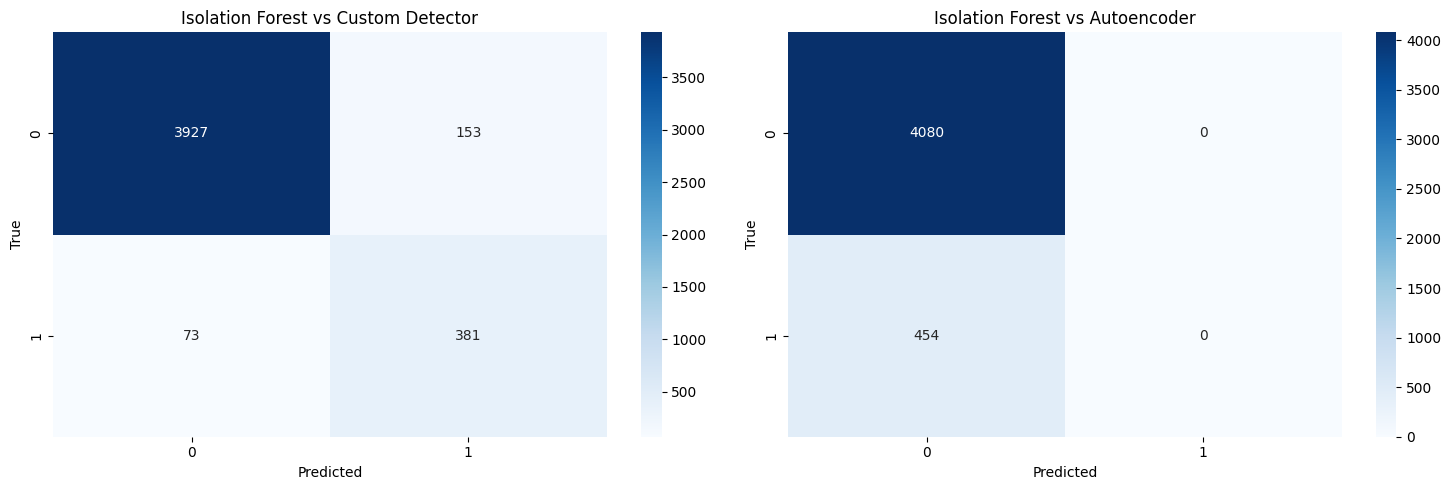

In [11]:
df_with_anomalies = main(df)